In [ ]:
!pip install darts

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts import TimeSeries
from darts.metrics import mape
from darts.models import BlockRNNModel, ExponentialSmoothing, RNNModel
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import logging
warnings.filterwarnings('ignore')

In [ ]:
# read data
series = AirPassengersDataset().load()
series

In [4]:
pd.Timestamp("19590101")

Timestamp('1959-01-01 00:00:00')

In [5]:
train, val = series.split_after(pd.Timestamp("19590101"))

In [6]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
sseries_transformed = transformer.transform(series)

In [ ]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start =  series.start_time(), freq = series.freq_str, periods = 1000),
    attribute="year",
    one_hot=False,
)

year_series

In [ ]:
year_series = Scaler().fit_transform(series = year_series)
year_series

In [ ]:
month_series = datetime_attribute_timeseries(year_series, attribute="month", one_hot=True)
month_series

In [ ]:
covariate = year_series.stack(month_series)
covariate

In [16]:
cov_train, cov_val = covariate.split_after(pd.Timestamp("19590101"))

In [21]:
# LSTM initialization

model = RNNModel(model = "LSTM", hidden_dim = 20, batch_size = 16, n_epochs = 300,
                 optimizer_kwargs = {'lr': 1e-3}, model_name = 'Air_RNN',
                 log_tensorboard = True, random_state = 42, input_chunk_length = 14,
                 training_length = 20)

In [ ]:
# model fitting

model.fit(train_transformed, future_covariates= covariate,
          val_series= val_transformed, val_future_covariates= covariate, verbose = True)

In [ ]:
pred_series = model.predict(n = 36, future_covariates = covariate)
plt.figure(figsize=(8, 5))
sseries_transformed.plot(label = 'actual')
pred_series.plot(label = 'prediction')
plt.legend()
plt.show()
mape(pred_series, val_transformed)

In [ ]:
# Backtesting
backtest_series = model.historical_forecasts(sseries_transformed,
                                             future_covariates=covariate,
                                             start = pd.Timestamp("19590101"),
                                             forecast_horizon = 6,
                                             retrain = False, verbose =True)

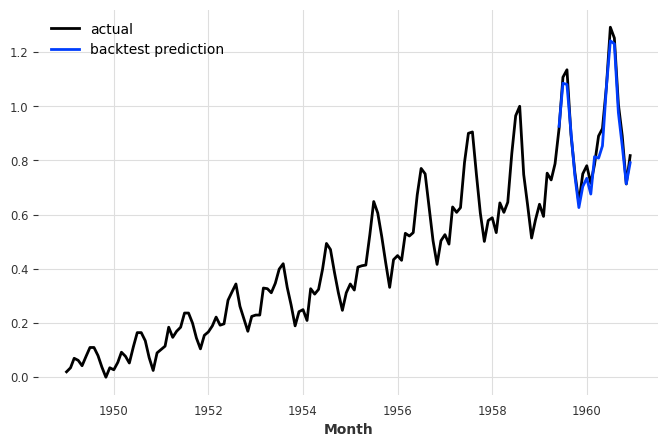

np.float64(3.6858385044330513)

In [32]:
plt.figure(figsize = (8,5))
sseries_transformed.plot(label = 'actual')
backtest_series.plot(label = 'backtest prediction')
plt.legend()
plt.show()
mape(backtest_series, val_transformed)

In [33]:
actual_data= transformer.inverse_transform(val_transformed)
pred_data = transformer.inverse_transform(pred_series)
mape(actual_data, pred_data)

np.float64(3.605387982259627)

## Sunspot Dataset

In [ ]:
from darts.datasets import SunspotsDataset

series_sunspot = SunspotsDataset().load()
series_sunspot.plot()

In [36]:
check_seasonality(series_sunspot, max_lag= 240)

(True, np.int64(125))

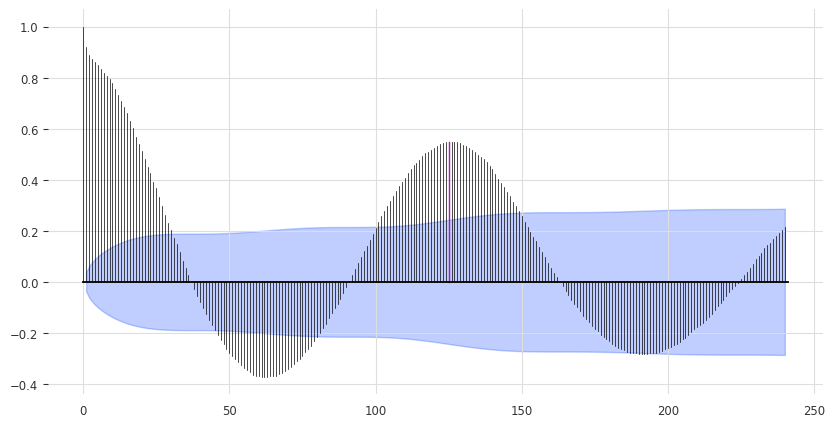

In [37]:
plot_acf(series_sunspot, 125, max_lag = 240)

In [38]:
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp("19401001"))

In [39]:
transformer_sp = Scaler()
train_sp_transformed = transformer_sp.fit_transform(train_sp)
val_sp_transformed = transformer_sp.transform(val_sp)
sseries_sp_transformed = transformer_sp.transform(series_sunspot)

In [40]:
model_sp = BlockRNNModel(model = 'GRU', input_chunk_length = 125,
                         output_chunk_length = 36, hidden_dim = 10, n_rnn_layers = 1,
                         batch_size = 32, n_epochs = 100, dropout = 0.1,
                         model_name = 'Sunspot_GRU', nr_epochs_val_period = 1,
                         optimizer_kwargs = {'lr': 1e-3}, log_tensorboard = True,
                         random_state = 42)

In [ ]:
model_sp.fit(train_sp_transformed, val_series= val_sp_transformed, verbose = True)

In [ ]:
pred_series = model_sp.historical_forecasts(sseries_sp_transformed,
                                           start = pd.Timestamp("19401001"),
                                           forecast_horizon = 36, stride = 10,
                                           retrain = False, verbose =True,
                                          last_points_only = True)

In [44]:
pred_ets_sp = ExponentialSmoothing(seasonal_periods = 120).historical_forecasts(
    sseries_sp_transformed, start = pd.Timestamp("19401001"), forecast_horizon = 36,
    retrain = True, verbose = True, stride = 10, last_points_only = True)

historical forecasts: 100%|██████████| 49/49 [01:20<00:00,  1.65s/it]


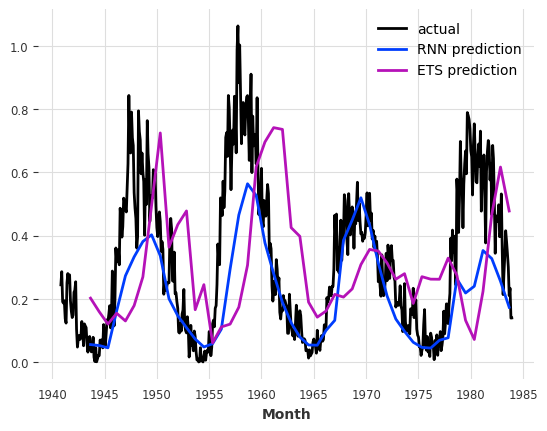

In [45]:
val_sp_transformed.plot(label = 'actual')
pred_series.plot(label = 'RNN prediction')
pred_ets_sp.plot(label = 'ETS prediction')
plt.legend()
plt.show()

In [46]:
mape(pred_series, val_sp_transformed)

np.float64(73.19011291402023)

In [47]:
mape(pred_ets_sp, val_sp_transformed)

np.float64(116.6358430941901)